# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import csv
with open('signnames.csv') as file:
    reader = csv.reader(file, delimiter=',', quoting=csv.QUOTE_NONE)
    data_csv = list(reader)
    
class_names = [ data_csv[idx][1] for idx in range(n_classes) ]

print(class_names)

['SignName', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vechiles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing']


In [4]:
# Lets import a few images of each class and plot them into a grid
import matplotlib.pyplot as plt
import random
import numpy as np

In [5]:
def plot_images(n_classes, sample_size, image_shape, y_train, y_names, X_train):
    
    fig, axesarr = plt.subplots(n_classes, sample_size, figsize=(sample_size, n_classes))
    fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
    
    for i_class in range(n_classes):
        
        i_images   = y_train == i_class
        num_images = sum(i_images)
        
        idx = np.random.choice(num_images, 
                               sample_size, 
                               replace = False)
        
        images = X_train[i_images,][idx,]
        
        for i_image in range(sample_size):
            
            axesarr[i_class, i_image].imshow( images[i_image].reshape(image_shape) )
            axesarr[i_class, i_image].set_xticks([])
            axesarr[i_class, i_image].set_yticks([])
            plt.axis('off')
    
    plt.show()

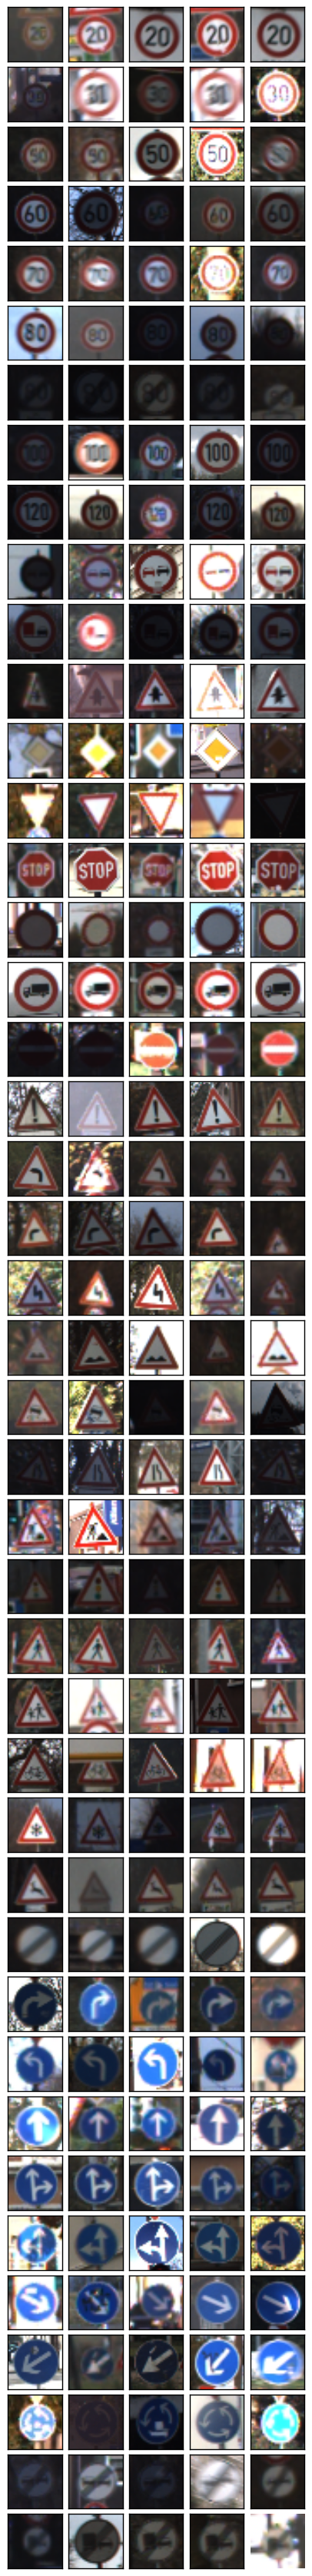

In [6]:
plot_images(n_classes, 5, image_shape, y_train, class_names, X_train)

In [7]:
# We want to preprocess the images befor feeding to the filter
# The paper by LeCun suggest that the Y channel suffices, on top
# of that, we want to apply adaptative histogram equalization to 
# improve edge recognition on the images (this simulates the local and
# global normalization hinted, but not detailed! in the paper as well, 
# kind of, not explained in the paper though)
import cv2

In [8]:
def normalize_greyscale(image_data):
    
    x_min = np.min(image_data)
    x_max = np.max(image_data)
    
    # Non extreme values are useful to avoid saturation
    a     = 0.1
    b     = 0.9
    
    return a + np.divide( (image_data - x_min ) * ( b - a), x_max - x_min) 

def preprocess_image(image, color=False):
    
    img   = cv2.cvtColor(image, cv2.COLOR_RGB2YUV);
    
    y,u,v = cv2.split(img)
    # I hand tuned these myself
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
    y     = clahe.apply(y)
    
    # Maybe we want color back, though LeCun suggest this is not needed
    if color:    
        yuv  = cv2.merge((y,u,v))
        rgb  = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
        return rgb
    
    gray = normalize_greyscale(y)
    return gray

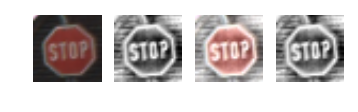

In [9]:
# Plot a single image under different preprocessing schemes

image = X_train[23000]
fig   = plt.figure(figsize=(4,1))

# original image
fig.add_subplot(1,4,1)
plt.imshow(image)
plt.axis('off')

# Processed Y channel of image
fig.add_subplot(1,4,2)
res = preprocess_image(image)
plt.imshow(res, cmap='gray')
plt.axis('off')

# Processed image in color
fig.add_subplot(1,4,3)
res = preprocess_image(image, True)
plt.imshow(res)
plt.axis('off')

# Processed image in RGB, then converted to gray, it seems more 'diluted' 
# than just the Y channel, so I do not recommend using it
fig.add_subplot(1,4,4)
res = preprocess_image(image, True)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.axis('off')

plt.show()

In [10]:
# Apply the same technique for a random selection of train images
def plot_proc_images(n_classes, sample_size, image_shape, y_train, y_names, X_train):
    
    fig, axesarr = plt.subplots(n_classes, 2*sample_size, figsize=(2*sample_size, n_classes))
    fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
    
    for i_class in range(n_classes):
        
        i_images   = y_train == i_class
        num_images = sum(i_images)
        
        idx = np.random.choice(num_images, 
                               sample_size, 
                               replace = False)
        
        images = X_train[i_images,][idx,]
        
        for i_image in range(sample_size):
            
            image = images[i_image].reshape(image_shape)
            axesarr[i_class, 2*i_image].imshow(image)
            axesarr[i_class, 2*i_image].set_xticks([])
            axesarr[i_class, 2*i_image].set_yticks([])
            plt.axis('off')
            
            image = preprocess_image(image)
            axesarr[i_class, 2*i_image + 1].imshow(image, cmap='gray')
            axesarr[i_class, 2*i_image + 1].set_xticks([])
            axesarr[i_class, 2*i_image + 1].set_yticks([])
            plt.axis('off')
    
    plt.show()

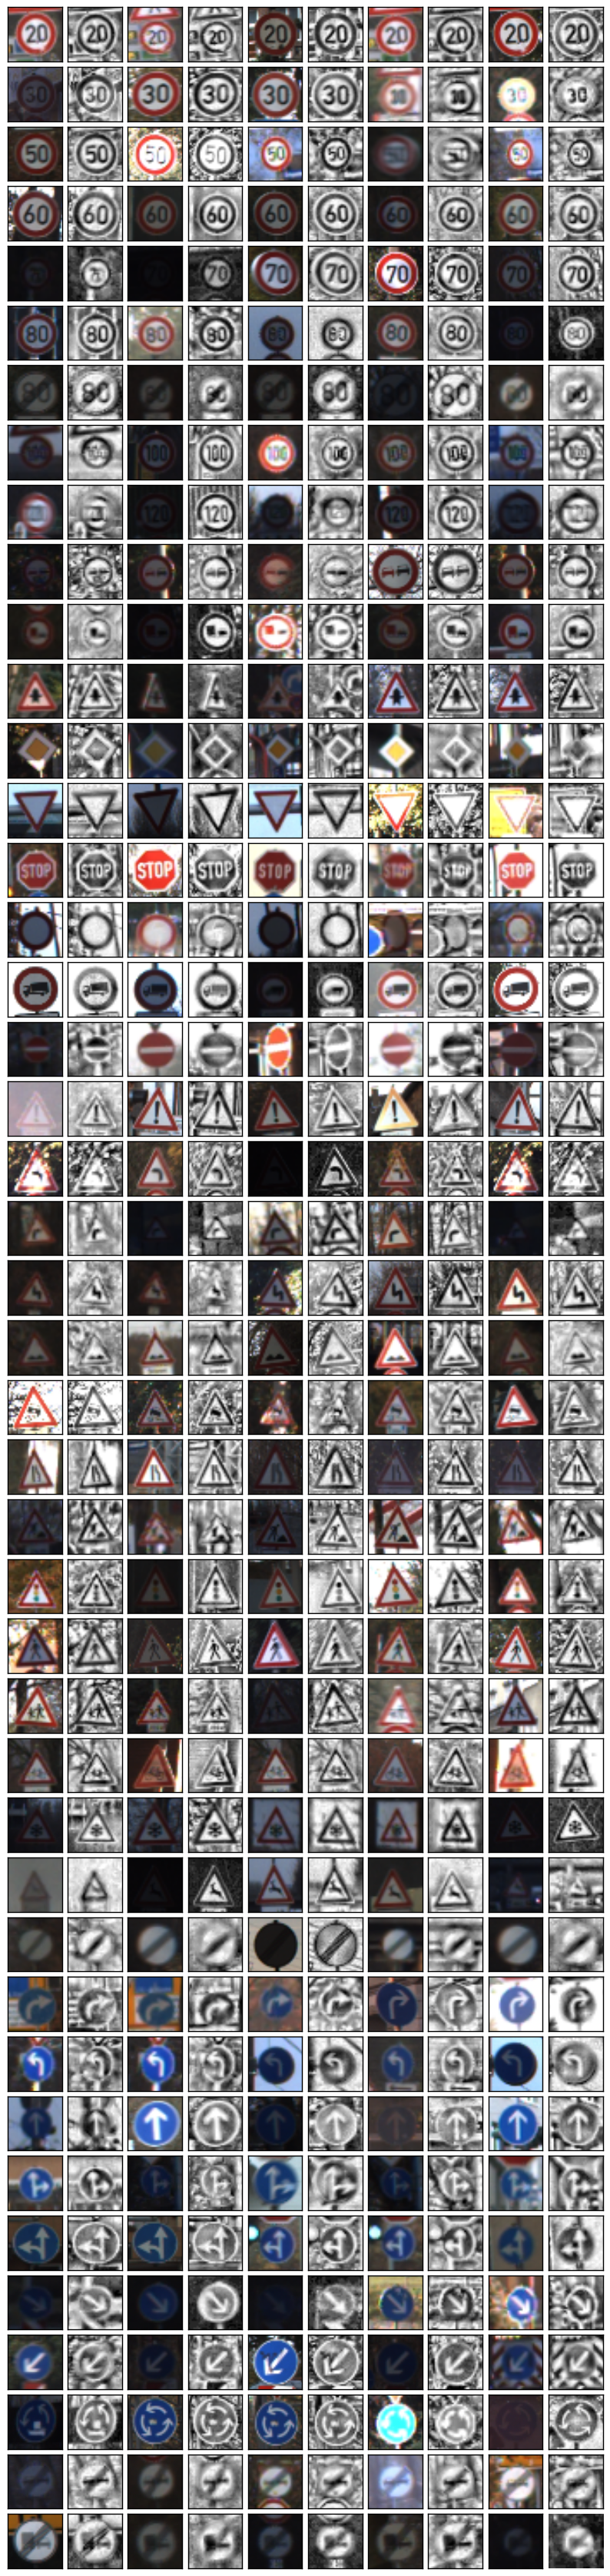

In [11]:
plot_proc_images(n_classes, 5, image_shape, y_train, class_names, X_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

from datetime import timedelta
import time
import math
import os

In [13]:
# Again, to some extent, I will adapt some functions from HvassLabs

# First, one hot encode the data
encoder = LabelBinarizer()
encoder.fit(y_train)
# Encode
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)
# Change fo float for TF
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [14]:
# Get some general data dimensions

# We already know the size of the images, and that they are squares
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 43 signals
num_classes = 43

In [15]:
# Preprocess all the data, also, convert the image to values between
# 0 and 1 in grayscale. I want to make this inside a special function,
# and pickle the output, since this can take a pretty long time on a
# slow computer

def preprocess_all_images(X_train, X_test, img_size):
    
    # Preallocate space for all images, for just a few tens of thousands of 
    # small images this should not need advanced caching techniques
    n_train = X_train.shape[0]
    n_test  = X_test.shape[0]
    
    train_features = np.zeros( [n_train, img_size, img_size] )
    test_features  = np.zeros( [n_test,  img_size, img_size] )

    for i in range(n_train):
        train_features[i,] = preprocess_image(X_train[i])
    for i in range(n_test):
        test_features[i,]  = preprocess_image( X_test[i] )
    
    return train_features, test_features

Loading data from pickle fie...

First image of processed train set


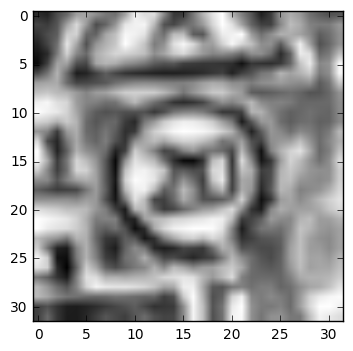


Final shape of train set
(39209, 1024)

First image of randomized train set


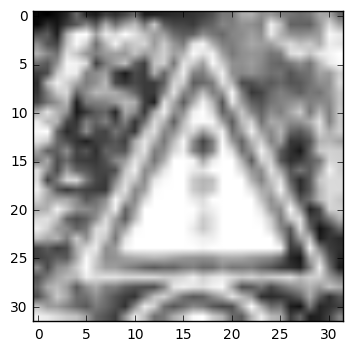

In [16]:
# Get processed image data

pickle_file = 'traffic_gray.pickle'

# If not exists, preprocess all images again
if not os.path.isfile(pickle_file):
    print('Preprocess all images in the set...')
    train_features, test_features = preprocess_all_images(X_train, X_test, img_size)
    # Save to pickle file
    print('Saving data to pickle fie...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_features': train_features,
                    'test_features': test_features,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

# Do note that I reuse variable names, to reduce mem footprint
with open(pickle_file, 'rb') as f:
    print('Loading data from pickle fie...')
    pickle_data = pickle.load(f)
    train_features = pickle_data['train_features']
    test_features = pickle_data['test_features']
    del pickle_data  # Free up memory

# Show a sinlge image for confirmation
print('\nFirst image of processed train set')
plt.imshow(train_features[0], cmap='gray')
plt.show()

# It is also in a square format, and so we might want to reshape it to
# simple vectors for easier manipulation
n_train = train_features.shape[0]
n_test  = test_features.shape[0]
train_features = train_features.reshape(n_train,img_size * img_size)
test_features  =  test_features.reshape(n_test, img_size * img_size)

# Random reshuffle of sets
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.0,
    random_state=1)

print('\nFinal shape of train set')
print(train_features.shape)

# We wont need these now
del valid_features
del valid_labels

# Show a sinlge image for confirmation
print('\nFirst image of randomized train set')
plt.imshow(train_features[0].reshape((32,32)), cmap='gray')
plt.show()

In [17]:
# Specify the hyperparameters of the network, I guess it could be bigger,
# but these params gave 94% accuracy, enough for now

filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 100        # There are 81 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 81         # There are 64 of these filters.

# Convolutional Layer 3.
filter_size3 = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 49 of these filters.

# Fully-connected layer.
fc_size1 = 400            # Number of neurons in fully-connected layer.
fc_size2 = 200            # Number of neurons in fully-connected layer.

In [18]:
# Taken from Hvass Labs, with minor modifications

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [19]:
# I want a better way to get batches...
# This code is from Vivek Yadav
# I think doing it this way adds a lot to the runtime (~20%)
# but ok...

def random_batch(Image_train, labels_train, batch_size):
    # Number of images in the training-set.
    num_images = len(Image_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = Image_train[idx, :]
    labels_batch   = labels_train[idx]

    return features_batch, labels_batch

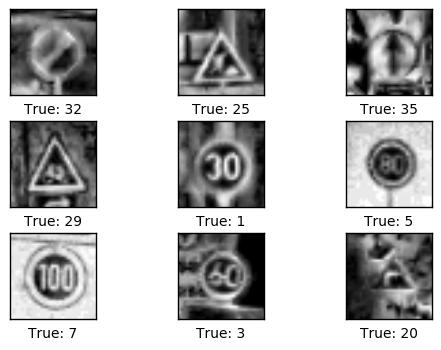

In [20]:
# Plot a few random images from the set with labels
images, labels = random_batch(train_features, train_labels, 9)
cls_true = np.argmax(labels, axis=1)
plot_images(images=images, cls_true=cls_true)

In [21]:
# These are taken from HvassLabs for ease of writing, in tutorial 2
# I completed the tutorials and exercises myself as well

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [22]:
# Set placeholder variables
x          = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image    = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true     = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
keep_prob  = tf.placeholder(tf.float32)

# Useful for the saver
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [23]:
# Define the network
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    
layer_conv2, weights_conv2 = \
new_conv_layer(input=layer_conv1,
               num_input_channels=num_filters1,
               filter_size=filter_size2,
               num_filters=num_filters2,
               use_pooling=True)

layer_conv3, weights_conv3 = \
new_conv_layer(input=layer_conv2,
               num_input_channels=num_filters2,
               filter_size=filter_size3,
               num_filters=num_filters3,
               use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv3)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)

layer_dropout1 = tf.nn.dropout(layer_fc1, keep_prob)

layer_fc2 = new_fc_layer(input=layer_dropout1,
                         num_inputs=fc_size1,
                         num_outputs=fc_size2,
                         use_relu=True)

layer_dropout2 = tf.nn.dropout(layer_fc2, keep_prob)

layer_fc3 = new_fc_layer(input=layer_dropout2,
                         num_inputs=fc_size2,
                         num_outputs=num_classes,
                         use_relu=False)

y_pred = tf.nn.softmax(layer_fc3)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [24]:
# Define optimization and performance stuff
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost, global_step=global_step)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
# Saver for ease of retraining
saver = tf.train.Saver(max_to_keep=100)
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = save_dir + 'traffic_signs'

In [26]:
# Start TF session etc
session = tf.Session()
session.run(tf.initialize_all_variables())

In [27]:
# Use a smaller batch size 
train_batch_size = 100
test_batch_size  = 100

# These are too costly right now, since 30k = 300 * 100
# I would recommend doing this every 300 iters, but then
# the improvement step would be way too large, because we
# woould need to eval the entire test set, and it has >10k
# items! But ok... 

#best_validation_accuracy = 0.0
#last_improvement         = 0
#require_improvement      = 1000

In [28]:
# This is code from HvassLabs with minor modifications

def optimize(num_iterations):

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(train_features, train_labels, train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob: 0.8}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if (i_global % 100 == 0) or (i == (num_iterations - 1)):

            # Calculate the accuracy on the training-batch.
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Message for printing.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, acc_train))
            
        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [29]:
# Also taken from Hvass with minor modifications

def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_features[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = np.argmax(test_labels[incorrect], axis = 1)
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = np.argmax(test_labels, axis = 1)
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(test_features)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    cls_test = np.argmax(test_labels, axis = 1)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = test_features[i:j, :]

        # Get the associated labels.
        labels = test_labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     keep_prob:1}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = cls_test

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Accuracy on Test-Set: 3.3% (416 / 12630)
Example errors:


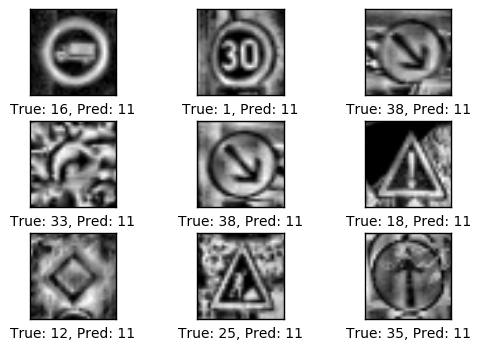

Confusion Matrix:
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


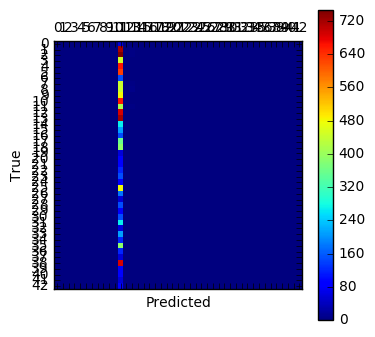

In [30]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [31]:
optimize(num_iterations=1)

Global Step:      1, Training Batch Accuracy:   4.0%
Saved checkpoint.
Time usage: 0:00:01


In [32]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.initialize_all_variables())

Trying to restore last checkpoint ...
Restored checkpoint from: checkpoints/traffic_signs-1


In [33]:
optimize(num_iterations=50000)

Global Step:    100, Training Batch Accuracy:   6.0%
Global Step:    200, Training Batch Accuracy:  22.0%
Global Step:    300, Training Batch Accuracy:  30.0%
Global Step:    400, Training Batch Accuracy:  56.0%
Global Step:    500, Training Batch Accuracy:  49.0%
Global Step:    600, Training Batch Accuracy:  71.0%
Global Step:    700, Training Batch Accuracy:  76.0%
Global Step:    800, Training Batch Accuracy:  76.0%
Global Step:    900, Training Batch Accuracy:  79.0%
Global Step:   1000, Training Batch Accuracy:  83.0%
Saved checkpoint.
Global Step:   1100, Training Batch Accuracy:  83.0%
Global Step:   1200, Training Batch Accuracy:  84.0%
Global Step:   1300, Training Batch Accuracy:  84.0%
Global Step:   1400, Training Batch Accuracy:  86.0%
Global Step:   1500, Training Batch Accuracy:  88.0%
Global Step:   1600, Training Batch Accuracy:  90.0%
Global Step:   1700, Training Batch Accuracy:  91.0%
Global Step:   1800, Training Batch Accuracy:  94.0%
Global Step:   1900, Trainin

KeyboardInterrupt: 

Accuracy on Test-Set: 96.0% (12126 / 12630)
Example errors:


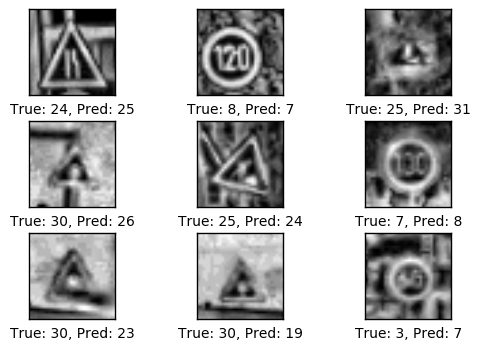

Confusion Matrix:
[[ 60   0   0 ...,   0   0   0]
 [  1 713   1 ...,   0   0   0]
 [  0   5 740 ...,   1   0   0]
 ..., 
 [  3   1   0 ...,  68   0   0]
 [  0   0   0 ...,   0  48   0]
 [  0   0   0 ...,   0   0  75]]


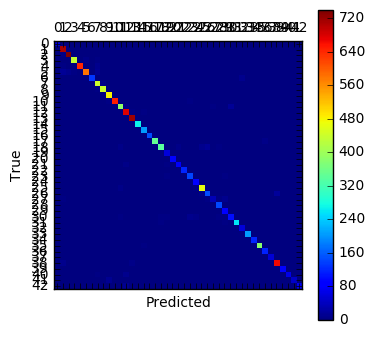

In [40]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [34]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [35]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [36]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [37]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [38]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [39]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.